In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from focal_loss import SparseCategoricalFocalLoss
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import RNN, GRU, LSTM, Dense, Input, Embedding, Dropout, Activation, concatenate
from tensorflow.keras.layers import Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, dot, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

In [2]:
train_data = pd.read_csv('clean_data/train.csv')
test_data = pd.read_csv('clean_data/val.csv')
fire_data = pd.read_csv('clean_data/test.csv')

In [3]:
#train_data.describe()
#test_data.describe()
fire_data.describe()

,news_text
count,400
unique,398
top,ناظرین جب تک پسند کریں گے کام کروں گی: سشمیتا...
freq,2


In [4]:
train_data.head()

,Unnamed: 0,news_text,label
0,410,﻿آئن سٹائن کے اپنے ہاتھ کا وہ خط متوقع کے عين...,1
1,577,نئی دہلی 15 دسمبر(ایجنسی) بین الاقوامی سطح پ...,1
2,221,نئی دہلی 5 دسمبر(ایجنسی) دہلی کے تاج ہوٹل میں...,0
3,200,میلبرن (نیوز ڈیسک) کہتے ہیں کہ وزن ایک بار ب...,0
4,486,نیوزی لینڈ 10 مئی (ایجنسی) امریکہ میں ماہرین ...,1


In [5]:
fire_data.head()

,news_text
0,چین کی جانب سے پاکستان کی مدد کرنے سے انکا...
1,چین کی جانب سے پاکستان کی مدد کرنے سے انکا...
2,مرغی اور انڈوں کی قیمت میں مسلسل کمی کا اعلا...
3,2017 2018 کے مالی سال میں تجارتی خسارہ مزی...
4,سٹاک مارکیٹ میں کام کرنے والوں کےلئے بری خبر ...


In [6]:
fire_data.isnull().any()

news_text    False
dtype: bool

In [7]:
test_data.isnull().any()

Unnamed: 0    False
news_text     False
label         False
dtype: bool

In [8]:
# Furhter actions on any columns is not required, because no columns has any missing data.

In [9]:

y = train_data["label"].values

y_val = test_data["label"].values


In [10]:
train_sentences = train_data["news_text"].fillna("fillna").str.lower()
test_sentences = test_data["news_text"].fillna("fillna").str.lower()
fire_sentences = fire_data["news_text"].fillna("fillna").str.lower()

In [11]:
max_features = 10000
max_len = 250
embed_size = 300

In [12]:
tokenizer = Tokenizer(max_features)
tokenizer.fit_on_texts(list(train_sentences))

In [13]:
tokenized_train_sentences = tokenizer.texts_to_sequences(train_sentences)
tokenized_test_sentences = tokenizer.texts_to_sequences(test_sentences)
tokenized_fire_sentences = tokenizer.texts_to_sequences(fire_sentences)

In [14]:
len(train_sentences[94].split(" "))

264

In [15]:
#tokenized_train_sentences[1]

In [16]:
train_sentences[5]

' لندن (ویب ڈیسک) آج کل کے دور میں ہر کوئی بالخصوص خواتین خوبصورت اور رنگ گورا کرنے سمیت کم عمر نظر آنے کی دوڑ میں لگی ہوئی ہیں جن افراد کا رنگ گورا گندمی ہوتا ہے انہیں گورا ہونے اور جو گورے ہیں انہیں گندمی ہونے کا شوق ہے اس دور میں لوگ بہت سی ایسی مہنگی کریمیں اور ماسک وغیرہ استعمال کرتے ہیں جن سے انہیں وقتی طور پر تو اپنے متعلقہ نتائج مل جاتے ہیں لیکن بعدازاں نقصان اٹھانا پڑتا ہے بہت سی لڑکیاں اسی کوشش میں اپنے چہرے کی پلاسٹک سرجری بھی کروا لیتی ہیں جس کے سنگین نتائج سے وہ آشنا ہوتی ہیں حال ہی میں رپورٹ کے مطابق ایک لڑکی نے پرکشش نظر آنے کی کوشش میں اپنی شکل کا حُلیہ خراب کر لیا ہے  لیکن اب پچھتائے کیا ہوت جب چڑیاں چگ گئیں کھیت دی مرر کے مطابق اس ماہر کا نام مکتیہے جو ایک نامیاتی سکن کیئر کمپنی کی مالک بھی ہے اس نے بتایا ہے کہ  گھریلو ٹوٹکوں سے رنگ گورا کرنا انتہائی آسان اور سستا طریقہ ہے جیسا کہ کریم میں گندم کا آٹا چاول کا آٹا سوڈا لیموں اوپٹن اور ہلدی کے استعمال سے آپ اپنا رنگ گورا کر سکتے ہیں اگر چند دن اس پر عمل کیا جائے تو آپ اپنی عمر سے کئی سال چھوٹے لگنے لگیں گے مکتی کا مزید 

In [17]:
#tokenized_train_sentences[5]

In [18]:
train_padding = pad_sequences(tokenized_train_sentences, max_len)
test_padding = pad_sequences(tokenized_test_sentences, max_len)
fire_padding = pad_sequences(tokenized_fire_sentences, max_len)

In [19]:
import gensim
from gensim.models import word2vec
from gensim.models.fasttext import FastText

word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index)+1, 300))

print(len(word_index))

model = gensim.models.KeyedVectors.load_word2vec_format('urduvec_140M_100K_300d.bin', binary=True) #urduvec_140M_100K_300d.bin

b = 0
for word, i in word_index.items():
    try:
        embedding_matrix[i] = model.wv[word]
    except KeyError:
        embedding_matrix[i] = np.random.uniform(-0.25,0.25,300)
        b = b + 1
print('there are %d words not in model'%b)
print('out of %d words'%i)



15299
there are 5063 words not in model
out of 15299 words


/home/reddy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


In [20]:
image_input = Input(shape=(max_len, ))
X = Embedding(len(word_index)+1, embed_size, weights=[embedding_matrix])(image_input)
X = Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(X)
# Dropout and R-Dropout sequence, inspired by Deep Learning with Python - Francois Chollet

#X1 = bi_modal_attention(X, X)

avg_pl = GlobalAveragePooling1D()(X)
max_pl = GlobalMaxPooling1D()(X)

conc = concatenate([avg_pl, max_pl])

#o1 = dot([max_pl, avg_pl], axes=[1, 1])
#a1 = multiply([o1, max_pl])

X = Dense(1, activation="sigmoid")(max_pl)
model = Model(inputs=image_input, outputs=X)

In [21]:

#odel.compile(loss=SparseCategoricalFocalLoss(gamma=2), optimizer='adam', metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
saved_model = "model3.hdf5"

checkpoint = ModelCheckpoint(saved_model, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=10)
callbacks_list = [checkpoint, early]

In [23]:
batch_sz = 25
epoch = 25
#model.fit(train_padding, y, batch_size=batch_sz, epochs=epoch, validation_split=0.1, callbacks=callbacks_list)

history = model.fit(train_padding, y, batch_size=batch_sz, epochs=epoch, callbacks=callbacks_list, validation_data=(test_padding, y_val))

Epoch 1/25
26/26 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.5345
Epoch 00001: val_accuracy improved from -inf to 0.58779, saving model to model3.hdf5
26/26 [==============================] - 16s 630ms/step - loss: 0.6954 - accuracy: 0.5345 - val_loss: 0.6707 - val_accuracy: 0.5878
Epoch 2/25
26/26 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.5878
Epoch 00002: val_accuracy did not improve from 0.58779
26/26 [==============================] - 23s 883ms/step - loss: 0.6648 - accuracy: 0.5878 - val_loss: 0.6745 - val_accuracy: 0.5649
Epoch 3/25
26/26 [==============================] - ETA: 0s - loss: 0.6256 - accuracy: 0.6834
Epoch 00003: val_accuracy improved from 0.58779 to 0.68702, saving model to model3.hdf5
26/26 [==============================] - 22s 836ms/step - loss: 0.6256 - accuracy: 0.6834 - val_loss: 0.6441 - val_accuracy: 0.6870
Epoch 4/25
26/26 [==============================] - ETA: 0s - loss: 0.5874 - accuracy: 0.7806


In [24]:
from tensorflow.keras.models import load_model

weights = load_model('model3.hdf5').get_weights()
model.set_weights(weights)
test_values = model.predict([fire_padding], batch_size=25, verbose=1)


16/16 [==============================] - 1s 47ms/step


In [25]:
test_labels = [1 if x >=0.5 else 0 for x in test_values]
print(test_labels)
len(test_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

400

In [26]:
import csv

inputfile = open("clean_data/test.csv","r")
csv_reader = csv.reader(inputfile)
data_fire = list(csv_reader)

csv_m1 = open("submissions/model3.csv", "w+")
writer = csv.writer(csv_m1, delimiter=",")

writer.writerow(["File No", "Real/Fake"])
for i in range(len(test_labels)):
    
    if test_labels[i] == 0:
        writer.writerow([i+1, "R"])
    elif test_labels[i] == 1:
        writer.writerow([i+1, "F"])
    else:
        #pass
        print("error: ", i)
        
#outfile.close()
csv_m1.close()

In [27]:
#from sklearn.metrics import classification_report
#target_names = ['real', 'fake']
#print(classification_report(y_val, test_values.round(), target_names=target_names))

[0.5877862572669983, 0.5648854970932007, 0.6870229244232178, 0.6297709941864014, 0.6641221642494202, 0.7633587718009949, 0.7862595319747925, 0.7442747950553894, 0.7824427485466003, 0.8282442688941956, 0.8091602921485901, 0.8129770755767822, 0.8282442688941956, 0.8129770755767822, 0.805343508720398, 0.8129770755767822, 0.8015267252922058, 0.8015267252922058, 0.7977099418640137, 0.7824427485466003] [0.5344827771186829, 0.5877742767333984, 0.6833855509757996, 0.7805642485618591, 0.8009404540061951, 0.8652037382125854, 0.8871473073959351, 0.9090909361839294, 0.9357366561889648, 0.9435736536979675, 0.9717868566513062, 0.9670846462249756, 0.9843260049819946, 0.9811912178993225, 0.9921630024909973, 0.9921630024909973, 0.9905956387519836, 0.9890282154083252, 0.9984325766563416, 0.9984325766563416]


Text(0.5, 1.0, 'loss')

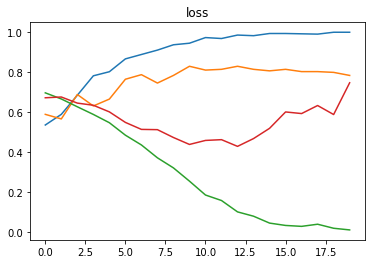

In [28]:
import matplotlib.pyplot as plt 

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

print(val_acc,acc)
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs,acc)
plt.plot(epochs,val_acc)
plt.title("accuracy")


plt.plot(epochs,loss)
plt.plot(epochs,val_loss)
plt.title("loss")


